## PHẦN 1: CÀI ĐẶT, IMPORTS & THIẾT LẬP BAN ĐẦU

In [1]:
# ==============================================================================
# CELL 1.1: CÀI ĐẶT THƯ VIỆN & BIẾN MÔI TRƯỜNG (CẬP NHẬT)
# ==============================================================================
import os
import json
import asyncio
import operator
import time 
from typing import TypedDict, Annotated, List, Dict, Any, Literal, Optional, Union

# Tải các biến môi trường
from dotenv import load_dotenv 
load_dotenv()

# LangChain & LangGraph
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.pydantic_v1 import BaseModel, Field
# --- NÂNG CẤP: Chuyển sang thư viện Google Generative AI (dành cho AI Studio) ---
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages

# --- NÂNG CẤP: Thêm công cụ tìm kiếm ---
from langchain_community.tools.tavily_search import TavilySearchResults

# Thư viện hỗ trợ & Kho tri thức
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from rich.console import Console
from rich.markdown import Markdown
from rich.pretty import pprint
from IPython.display import Image, display

c:\Users\Hi\Documents\IAI - UET\AI-Lesson-Plan-Generator\plan_venv\Lib\site-packages\IPython\core\interactiveshell.py:3699: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
# ==============================================================================
# CELL 1.2: CẤU HÌNH LOG & CÁC HÀM IN ẤN
# ==============================================================================
from langchain_groq import ChatGroq
# --- CẤU HÌNH LOG ---
VERBOSE_MODE = True

# --- KHỞI TẠO CÁC CÔNG CỤ IN ẤN ---
console = Console()

def print_step(message: str):
    if VERBOSE_MODE:
        console.print(f"\n[bold cyan]>[/bold cyan] {message}")

def print_result(data: Any, title: str = "Kết quả"):
    if VERBOSE_MODE:
        console.print(f"[bold green]✔️ {title}:[/bold green]")
        pprint(data, expand_all=True)
        
def print_warning(message: str):
    if VERBOSE_MODE:
        console.print(f"[bold yellow]⚠️  {message}[/bold yellow]")

In [4]:
# ==============================================================================
# CELL 1.3: KHỞI TẠO LLM (NÂNG CẤP SANG GOOGLE AI STUDIO)
# ==============================================================================
try:
    llm = ChatGoogleGenerativeAI(
        model="gemini-2.5-flash", # Sử dụng model mới nhất và mạnh nhất
        temperature=0.1,
        google_api_key=os.getenv("GOOGLE_API_KEY")
    )
    print("✅ LLM (Gemini 2.5 Flash từ Google AI Studio) đã được khởi tạo thành công.")
except Exception as e:
    print(f"❌ LỖI: Không thể khởi tạo LLM. Hãy chắc chắn bạn đã cài 'langchain-google-genai' và có GOOGLE_API_KEY trong file .env. Lỗi: {e}")
    llm = None

✅ LLM (Gemini 2.5 Flash từ Google AI Studio) đã được khởi tạo thành công.


## PHẦN 2: ĐỊNH NGHĨA STATE CỦA HỆ THỐNG


In [14]:
# ==============================================================================
# CELL 1.4: TẢI KHO TRI THỨC (RAG)
# ==============================================================================
# --- TẢI KHO TRI THỨC ---
BASE_VECTOR_STORE_PATH = "vector_store"
vector_store = None
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

if os.path.exists(BASE_VECTOR_STORE_PATH):
    subdirectories = [f.path for f in os.scandir(BASE_VECTOR_STORE_PATH) if f.is_dir()]
    if not subdirectories:
        print(f"❌ LỖI: Không tìm thấy thư mục con nào trong '{BASE_VECTOR_STORE_PATH}'.")
    else:
        try:
            print_step(f"Đang tải và hợp nhất các kho tri thức từ {len(subdirectories)} thư mục...")
            # Tải kho tri thức đầu tiên để làm cơ sở
            first_store_path = subdirectories.pop(0)
            vector_store = FAISS.load_local(first_store_path, embeddings, allow_dangerous_deserialization=True)
            print(f"✅ Đã tải thành công kho tri thức cơ sở: '{os.path.basename(first_store_path)}'")

            # Hợp nhất các kho tri thức còn lại
            for store_path in subdirectories:
                if os.path.exists(os.path.join(store_path, "index.faiss")):
                    temp_store = FAISS.load_local(store_path, embeddings, allow_dangerous_deserialization=True)
                    vector_store.merge_from(temp_store)
                    print(f"✅ Đã hợp nhất thành công: '{os.path.basename(store_path)}'")
                else:
                    print_warning(f"Bỏ qua thư mục '{os.path.basename(store_path)}' vì không chứa file index.faiss.")
            
            print("\n[bold green]✔️ Tất cả các kho tri thức RAG đã được tải và hợp nhất thành công.[/bold green]")

        except Exception as e:
            print(f"❌ LỖI trong quá trình tải hoặc hợp nhất kho tri thức: {e}")
else:
    print(f"❌ LỖI: Không tìm thấy thư mục gốc của kho tri thức tại '{BASE_VECTOR_STORE_PATH}'.")


c:\Users\Hi\Documents\IAI - UET\AI-Lesson-Plan-Generator\plan_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


> Đang tải và hợp nhất các kho tri thức từ 2 thư mục...

✅ Đã tải thành công kho tri thức cơ sở: 'sgk_toan_12_1'
✅ Đã hợp nhất thành công: 'sgk_toan_9'

[bold green]✔️ Tất cả các kho tri thức RAG đã được tải và hợp nhất thành công.[/bold green]


In [15]:
# ==============================================================================
# CELL 2.1: ĐỊNH NGHĨA STATE NÂNG CAO (v9.0)
# ==============================================================================
from typing import TypedDict, Annotated, List, Dict, Any, Literal, Optional, Union
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
import operator

# --- Hàm tiện ích (giữ nguyên) ---
def merge_dicts(dict1: Dict[str, Any], dict2: Dict[str, Any]) -> Dict[str, Any]:
    merged = dict1.copy()
    for key, value in dict2.items():
        if key in merged and isinstance(merged[key], dict) and isinstance(value, dict):
            merged[key] = merge_dicts(merged[key], value)
        else:
            merged[key] = value
    return merged

# --- Cấu trúc dữ liệu con (giữ nguyên) ---
class DetailedTask(TypedDict):
    task_id: int
    task_name: str
    task_description: str
    estimated_duration: int 
    status: Literal["pending", "completed"]

# === NÂNG CẤP V9.0: CÁC CẤU TRÚC DỮ LIỆU MỚI CHO TƯ DUY SÂU ===
class DifferentiatedInstruction(TypedDict):
    """Gợi ý cho việc dạy học phân hóa trong một hoạt động."""
    for_struggling_students: str
    for_advanced_students: str

class StructuredContentItem(TypedDict):
    """Định nghĩa một hoạt động hoặc đánh giá có cấu trúc."""
    task_id: int
    activity_name: str
    question_or_description: str # Gộp 'question' và 'description'
    duration_minutes: int
    content_type: str # Gộp 'activity_type' và 'question_type'
    teacher_actions: List[str]
    solution_guide: Any
    answer: Optional[str] # Dành cho câu hỏi đánh giá
    differentiation: Optional[DifferentiatedInstruction]

class FinalStructuredPlan(TypedDict):
    """Định nghĩa cấu trúc JSON cho giáo án cuối cùng."""
    general_info: Dict[str, Any]
    learning_objectives: List[str]
    preparation: Dict[str, List[str]]
    knowledge_summary: str
    lesson_flow: List[StructuredContentItem]
    # pedagogical_explainer: Dict[str, Any] # Dành cho nâng cấp tương lai

# === NÂNG CẤP V9.0: STATE MỚI VỚI CÁC TRƯỜNG TRÍ TUỆ MỚI ===
class TeacherStateV5(TypedDict):
    # Các trường cơ bản
    original_request: str
    messages: Annotated[List[BaseMessage], add_messages]
    domain: Optional[str]
    
    # === NÂNG CẤP: student_persona giờ sẽ chứa cả chiến lược phân hóa ===
    student_persona: Optional[Dict[str, Any]] 
    
    # Các bước tuần tự ban đầu
    analyzed_objective: Optional[Any]
    pedagogy_strategy: Optional[Any]
    pedagogical_blueprint: Optional[List[str]]

    # Các trường nâng cao
    expanded_queries: Optional[List[str]]
    task_list: Optional[List[DetailedTask]]
    current_task_id: Optional[int]
    reflection_notes: Optional[str]
    agent_outputs: Annotated[Dict[str, Any], merge_dicts] 
    next_agent: str
    
    # Các trường tạm thời cho vòng lặp kiểm duyệt vi mô (Micro-loop)
    current_content_to_validate: Optional[Dict[str, Any]]
    validation_feedback: Optional[str]

    # === NÂNG CẤP: Output cuối cùng sẽ có 2 dạng ===
    final_structured_plan: Optional[FinalStructuredPlan] # Dạng JSON có cấu trúc
    final_markdown_plan: Optional[str] # Dạng Markdown để hiển thị

print("✅ 'TeacherStateV5' (v9.0 - Hỗ trợ Phân hóa & Cấu trúc) đã được định nghĩa.")

✅ 'TeacherStateV5' (v9.0 - Hỗ trợ Phân hóa & Cấu trúc) đã được định nghĩa.


In [16]:
# ==============================================================================
# CELL 2.2: NODE KHỞI TẠO STATE
# ==============================================================================
def initialize_state_node(state: TeacherStateV5) -> Dict[str, Any]:
    """
    Node đầu tiên trong graph.
    Lấy yêu cầu gốc từ tin nhắn đầu vào và điền vào trường 'original_request'.
    """
    print_step("`Initializer`: Đang khởi tạo trạng thái và lấy yêu cầu gốc...")
    user_request = state['messages'][-1].content
    return {"original_request": user_request}

print("✅ Node khởi tạo 'initialize_state_node' đã được định nghĩa.")

✅ Node khởi tạo 'initialize_state_node' đã được định nghĩa.


## PHẦN 3: ĐỊNH NGHĨA CÁC AGENT

In [17]:
# ==============================================================================
# CELL 3.1: HÀM TIỆN ÍCH, PERSONA & CÁC CẤU TRÚC DỮ LIỆU (NÂNG CẤP V9.0)
# ==============================================================================
import json
from langchain_core.pydantic_v1 import BaseModel, Field, schema_json_of
from typing import List, Dict, Any, Literal, Optional

# --- HÀM TIỆN ÍCH & PERSONA (giữ nguyên) ---
def format_solution_guide(guide: Any) -> str:
    if not guide: return "Chưa có hướng dẫn."
    if isinstance(guide, str): return guide
    if isinstance(guide, list): return "\n".join(f"- {step}" for step in guide)
    if isinstance(guide, dict): return "\n".join(f"- {key.replace('_', ' ').title()}: {value}" for key, value in guide.items())
    return str(guide)

def format_teacher_actions(actions: Optional[List[str]]) -> str:
    if not actions: return "Giáo viên quan sát và hỗ trợ chung."
    return "\n".join(f"  - {action}" for action in actions)

def update_agent_outputs(state: "TeacherStateV5", key: str, value: Any) -> Dict[str, Any]:
    outputs = state.get("agent_outputs", {}).copy()
    if key not in outputs: outputs[key] = []
    outputs[key].append(value)
    return {"agent_outputs": outputs}

SYSTEM_PERSONA_PROMPT = "BẠN LÀ MỘT TRỢ LÝ AI CHUYÊN NGHIỆP, ĐÓNG VAI TRÒ MỘT GIÁO VIÊN GIÀU KINH NGHIỆM TẠI VIỆT NAM. LUÔN LUÔN trả lời bằng TIẾNG VIỆT."

# === NÂNG CẤP V9.0: PYDANTIC MODELS MỚI CHO TƯ DUY SÂU ===

class DifferentiatedInstructionModel(BaseModel):
    """Gợi ý cụ thể cho việc dạy học phân hóa trong một hoạt động."""
    for_struggling_students: str = Field(description="Một gợi ý hoạt động, câu hỏi, hoặc sự hỗ trợ cụ thể cho nhóm học sinh yếu/gặp khó khăn.")
    for_advanced_students: str = Field(description="Một câu hỏi mở rộng, một thử thách, hoặc một hoạt động nâng cao cho nhóm học sinh giỏi.")

class LearningActivity(BaseModel):
    activity_name: str = Field(description="Tên của hoạt động học tập. Ví dụ: 'Thảo luận nhóm về ứng dụng của Tích phân'")
    description: str = Field(description="Mô tả chi tiết các bước HỌC SINH cần làm.")
    duration_minutes: int = Field(description="Thời gian ước tính (bằng SỐ PHÚT).")
    activity_type: str = Field(description="Phân loại hoạt động. Ví dụ: 'Thảo luận nhóm', 'Thực hành cá nhân'")
    teacher_actions: List[str] = Field(description="Danh sách các hành động CỤ THỂ của GIÁO VIÊN trong hoạt động này.")
    solution_guide: Optional[Any] = Field(description="Hướng dẫn giải hoặc các câu hỏi gợi mở cụ thể cho học sinh.")
    differentiation: Optional[DifferentiatedInstructionModel] = Field(description="Gợi ý phân hóa cụ thể cho hoạt động này.")

class AssessmentItem(BaseModel):
    activity_name: str = Field(description="Tên của hoạt động đánh giá. Ví dụ: 'Thử thách cuối bài'")
    question: str = Field(description="Nội dung câu hỏi hoặc đề bài toán cụ thể.")
    question_type: str = Field(description="Loại câu hỏi. Ví dụ: 'Tự luận', 'Trắc nghiệm'")
    teacher_actions: List[str] = Field(description="Danh sách các hành động CỤ THỂ của GIÁO VIÊN trong hoạt động này.")
    answer: str = Field(description="Đáp án chính xác và ngắn gọn.")
    solution_guide: Any = Field(description="Hướng dẫn giải chi tiết từng bước.")
    duration_minutes: int = Field(description="Thời gian ước tính (bằng SỐ PHÚT).")
    differentiation: Optional[DifferentiatedInstructionModel] = Field(description="Gợi ý phân hóa cụ thể cho hoạt động này, ví dụ một câu hỏi phụ khó hơn.")

class StudentPersona(BaseModel):
    learning_pace: Literal["nhanh", "trung bình", "chậm"] = Field(description="Tốc độ học tập chung của lớp.")
    engagement_style: Literal["chủ động", "thụ động", "hỗn hợp"] = Field(description="Mức độ tham gia chung của lớp.")
    special_notes: str = Field(description="Tóm tắt các đặc điểm nổi bật của lớp học.")

class StudentPersonaAndDifferentiation(StudentPersona):
    """Mở rộng StudentPersona để bao gồm cả chiến lược phân hóa tổng thể."""
    differentiation_strategy: DifferentiatedInstructionModel = Field(description="Chiến lược dạy học phân hóa tổng thể cho cả bài học dựa trên các đặc điểm của lớp.")

# --- Các model khác giữ nguyên ---
class DetailedTaskModel(BaseModel):
    task_name: str = Field(description="Tên của nhiệm vụ này.")
    task_description: str = Field(description="Mô tả chi tiết nhiệm vụ cần thực hiện.")
    estimated_duration: int = Field(description="Thời gian ước tính (bằng phút) cho nhiệm vụ này.")

class TaskListWithDuration(BaseModel):
    tasks: List[DetailedTaskModel]

class DetailedPedagogyChoice(BaseModel):
    name: str = Field(description="Tên của phương pháp sư phạm được chọn.")
    rationale: str = Field(description="Lý do tại sao phương pháp này phù hợp.")
    key_actions: List[str] = Field(description="Danh sách các hành động/hoạt động cốt lõi đặc trưng cho phương pháp này.")

class ValidationResult(BaseModel):
    is_valid: bool = Field(description="Nội dung có hợp lệ và chính xác về mặt chuyên môn không.")
    feedback: str = Field(description="Phản hồi chi tiết. Nếu không hợp lệ, hãy giải thích rõ ràng lỗi sai và gợi ý cách sửa.")

class Domain(BaseModel):
    domain: str = Field(description="Lĩnh vực học thuật chính của yêu cầu.")

class ExpandedQueries(BaseModel): queries: List[str]
class BestSnippets(BaseModel): best_snippets: List[str]
class ParsedObjective(BaseModel): action_verb: str; bloom_level: int; topic: str; grade_level: str; duration_minutes: Optional[int]
class TaskClassification(BaseModel): agent_category: Literal["activity_designer", "theory_synthesizer", "assessment_creator"]

class BlueprintStage(BaseModel):
    stage_name: str = Field(description="Tên của giai đoạn.")
    stage_objective: str = Field(description="Mô tả mục tiêu của giai đoạn này.")
    stage_direction: str = Field(description="Định hướng chung về hoạt động trong giai đoạn này.")

class PedagogicalBlueprint(BaseModel):
    blueprint: List[BlueprintStage]

print("✅ Các cấu trúc dữ liệu Pydantic (v9.0 - Hỗ trợ Phân hóa) đã được định nghĩa.")

✅ Các cấu trúc dữ liệu Pydantic (v9.0 - Hỗ trợ Phân hóa) đã được định nghĩa.


In [18]:
# ==============================================================================
# CELL 3.2: AGENT PHÂN TÍCH YÊU CẦU BAN ĐẦU (NÂNG CẤP V9.0)
# ==============================================================================
async def objective_interpreter_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Objective Interpreter` (v7.5) đang phân tích mục tiêu...")
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHIỆM VỤ:** Đọc yêu cầu của người dùng và trích xuất các thông tin sau.\n**YÊU CẦU:** \"{state['original_request']}\"\n**CÁC TRƯỜNG CẦN TRÍCH XUẤT:** `action_verb`, `bloom_level` (SỐ NGUYÊN), `topic`, `grade_level`, `duration_minutes`.\n**CHỈ TRẢ VỀ JSON.**"
    structured_llm = llm.with_structured_output(ParsedObjective, method="json_mode")
    try:
        parsed_result = await structured_llm.ainvoke(prompt)
        analyzed_objective_dict = parsed_result.dict()
        analyzed_objective_dict['constraints'] = {'duration_minutes': parsed_result.duration_minutes}
        del analyzed_objective_dict['duration_minutes']
        print_result(analyzed_objective_dict, "Mục tiêu & Ràng buộc đã phân tích")
        return {"analyzed_objective": analyzed_objective_dict}
    except Exception as e:
        print_warning(f"Lỗi tại Objective Interpreter: {e}. Sử dụng mục tiêu mặc định.")
        return {"analyzed_objective": { "action_verb": "soạn", "bloom_level": 3, "topic": state['original_request'], "grade_level": "9", "constraints": {"duration_minutes": 90} }}

async def domain_classifier_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Domain Classifier` (v7.5) đang xác định lĩnh vực chuyên môn...")
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHIỆM VỤ:** Đọc yêu cầu của người dùng và xác định lĩnh vực học thuật chính.\n**YÊU CẦU:** \"{state['original_request']}\"\n**LĨNH VỰC CÓ THỂ CHỌN:** 'Toán học', 'Vật lý', 'Hóa học', 'Sinh học', 'Văn học', 'Lịch sử', 'Địa lý', 'Ngoại ngữ', 'Tin học'.\n**YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với key `domain`."
    structured_llm = llm.with_structured_output(Domain, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        print_result(result.domain, "Lĩnh vực chuyên môn được xác định")
        return {"domain": result.domain}
    except Exception as e:
        print_warning(f"Lỗi tại Domain Classifier: {e}. Sử dụng lĩnh vực mặc định 'Toán học'.")
        return {"domain": "Toán học"}

# === NÂNG CẤP: Agent này giờ đây là một nhà tư vấn chiến lược ===
async def differentiated_instruction_advisor_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Differentiated Instruction Advisor` (v9.0) đang phân tích và đề xuất chiến lược phân hóa...")
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một chuyên gia sư phạm, chuyên về dạy học phân hóa.
    **NHIỆM VỤ:** Phân tích mô tả về lớp học dưới đây và đề xuất một chiến lược dạy học phân hóa TỔNG THỂ cho cả buổi học.
    **YÊU CẦU CỦA GIÁO VIÊN:** "{state['original_request']}"
    
    **CÁC BƯỚC SUY LUẬN (BẮT BUỘC):**
    1.  **Phân tích Đặc điểm:** Dựa vào các từ khóa như "yếu", "mất tập trung", "giỏi", "nhanh", "chậm", hãy xác định `learning_pace`, `engagement_style`, và tóm tắt vào `special_notes`.
    2.  **Đề xuất Chiến lược Phân hóa:** Dựa trên phân tích trên, hãy suy nghĩ và đề xuất:
        -   `for_struggling_students`: Một chiến lược cụ thể để **hỗ trợ** nhóm học sinh có thể gặp khó khăn. (Ví dụ: "Chia nhỏ nhiệm vụ, cung cấp phiếu bài tập có gợi ý công thức, cho phép thêm thời gian.")
        -   `for_advanced_students`: Một chiến lược cụ thể để **thử thách** nhóm học sinh khá giỏi. (Ví dụ: "Chuẩn bị các câu hỏi mở rộng 'Tại sao?' và 'Nếu... thì sao?', giao một bài toán ứng dụng thực tế nhỏ.")

    **YÊU CẦU ĐỊNH DẠNG:** BẮT BUỘC trả về một đối tượng JSON duy nhất tuân thủ schema `StudentPersonaAndDifferentiation`.
    """
    structured_llm = llm.with_structured_output(StudentPersonaAndDifferentiation, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        print_result(result.dict(), "Hồ sơ lớp học và Chiến lược Phân hóa")
        return {"student_persona": result.dict()}
    except Exception as e:
        print_warning(f"Lỗi tại Differentiated Instruction Advisor: {e}. Sử dụng hồ sơ mặc định.")
        fallback_persona = {
            "learning_pace": "trung bình",
            "engagement_style": "hỗn hợp",
            "special_notes": "Không có ghi chú đặc biệt.",
            "differentiation_strategy": {
                "for_struggling_students": "Quan sát và hỗ trợ thêm khi cần thiết.",
                "for_advanced_students": "Khuyến khích các em tìm tòi thêm."
            }
        }
        return {"student_persona": fallback_persona}

print("✅ Các agent phân tích yêu cầu ban đầu (v9.0 - Hỗ trợ Phân hóa) đã sẵn sàng.")

✅ Các agent phân tích yêu cầu ban đầu (v9.0 - Hỗ trợ Phân hóa) đã sẵn sàng.


In [19]:
# ==============================================================================
# CELL 3.3: AGENT LẬP KẾ HOẠCH CHIẾN LƯỢC (v7.5)
# ==============================================================================
async def pedagogy_strategist_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Pedagogy Strategist` (v7.5) đang xây dựng chiến lược sư phạm chi tiết...")
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **MỤC TIÊU BÀI HỌC:** {state.get('analyzed_objective')}
    **HỒ SƠ LỚP HỌC:** {state.get('student_persona')}
    **NHIỆM VỤ:** Dựa vào mục tiêu và hồ sơ lớp học, hãy chọn MỘT phương pháp sư phạm phù hợp nhất. Sau đó, phân tích phương pháp đó thành các hành động cốt lõi.
    **VÍ DỤ:** Nếu chọn 'Dạy học theo dự án', key_actions có thể là ["Giao dự án", "Học sinh làm việc nhóm", "Báo cáo sản phẩm"].
    **YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với các key `name`, `rationale`, `key_actions`.
    """
    structured_llm = llm.with_structured_output(DetailedPedagogyChoice, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        print_result(result.dict(), "Chiến lược sư phạm chi tiết")
        return {"pedagogy_strategy": result.dict()}
    except Exception as e:
        print_warning(f"Lỗi tại Pedagogy Strategist: {e}. Sử dụng chiến lược mặc định.")
        return {"pedagogy_strategy": {"name": "Dạy học giải quyết vấn đề", "rationale": "Mặc định do lỗi.", "key_actions": ["Nêu vấn đề", "Học sinh tìm giải pháp", "Trình bày kết quả"]}}

async def pedagogical_architect_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Pedagogical Architect` (v7.5) đang thiết kế kịch bản buổi học...")
    prompt = f"""{SYSTEM_PERSONA_PROMPT} Với vai trò là một chuyên gia thiết kế trải nghiệm học tập.
    **NHIỆM VỤ:** Xây dựng một "Bản thiết kế Sư phạm" - một kịch bản CẤP CAO cho buổi học.
    **QUY TẮC:**
    1.  Tạo ra 3-5 giai đoạn chính cho dòng chảy của buổi học.
    2.  Mỗi giai đoạn phải có tên (`stage_name`), mục tiêu (`stage_objective`), và định hướng (`stage_direction`).
    3.  Đảm bảo độ khó tăng tiến qua các giai đoạn.
    **THÔNG TIN PHÂN TÍCH:**
    - Mục tiêu: {state.get('analyzed_objective')}
    - Hồ sơ lớp học: {state.get('student_persona')}
    - Chiến lược Sư phạm: {state.get('pedagogy_strategy')}
    **YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với key là `blueprint`, giá trị là một danh sách các đối tượng Stage.
    """
    structured_llm = llm.with_structured_output(PedagogicalBlueprint, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        blueprint_list_of_strings = [f"{stage.stage_name}: {stage.stage_direction}" for stage in result.blueprint]
        print_result(blueprint_list_of_strings, "Bản thiết kế Sư phạm đã được tạo")
        return {"pedagogical_blueprint": blueprint_list_of_strings}
    except Exception as e:
        print_warning(f"Lỗi tại Pedagogical Architect: {e}. Sử dụng blueprint mặc định.")
        return {"pedagogical_blueprint": ["Giai đoạn 1: Giới thiệu bài học", "Giai đoạn 2: Luyện tập", "Giai đoạn 3: Đánh giá"]}

print("✅ Các agent lập kế hoạch chiến lược đã sẵn sàng.")

✅ Các agent lập kế hoạch chiến lược đã sẵn sàng.


In [20]:
# ==============================================================================
# CELL 3.4: AGENT TRUY XUẤT VÀ TỔNG HỢP KIẾN THỨC (RAG) (v7.5)
# ==============================================================================
async def query_expansion_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Query Expansion` (v7.5) đang phân tích yêu cầu...")
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHIỆM VỤ:** Tạo ra các cụm từ tìm kiếm đa dạng bằng tiếng Việt để tìm tài liệu.\n**CHỦ ĐỀ:** \"{state.get('analyzed_objective', {}).get('topic', '')}\"\n**LĨNH VỰC:** {state.get('domain', 'Chung')}\n**YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với key `queries`."
    structured_llm = llm.with_structured_output(ExpandedQueries, method="json_mode")
    try:
        response = await structured_llm.ainvoke(prompt)
        print_result(response.queries, "Các truy vấn tìm kiếm đã được mở rộng")
        return {"expanded_queries": response.queries}
    except Exception as e:
        print_warning(f"Lỗi tại Query Expansion: {e}. Sử dụng truy vấn gốc.")
        return {"expanded_queries": [state.get('analyzed_objective', {}).get('topic', '')]}

async def resource_scout_agent_v2(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Resource Scout` (v8.1 - Sửa lỗi) đang tìm kiếm và sàng lọc...")
    retriever = vector_store.as_retriever(search_kwargs={"k": 5})
    all_docs = []
    queries = state.get('expanded_queries', [state.get('analyzed_objective', {}).get('topic', '')])
    for query in queries:
        all_docs.extend(retriever.invoke(query))
    unique_docs_content = list({doc.page_content for doc in all_docs})[:8]
    print_step(f"Tìm thấy {len(all_docs)} tài liệu, sàng lọc còn {len(unique_docs_content)} đoạn văn bản độc nhất.")
    
    # --- Phần Re-ranker giữ nguyên ---
    rerank_prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHIỆM VỤ:** Đọc yêu cầu gốc và chọn ra 3-4 đoạn văn bản tiếng Việt phù hợp NHẤT từ danh sách dưới đây.\n**YÊU CẦU GỐC:** \"{state.get('original_request', '')}\"\n**DANH SÁCH TÀI LIỆU:** {json.dumps(unique_docs_content, ensure_ascii=False)}\n**YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với key `best_snippets`."
    structured_llm_reranker = llm.with_structured_output(BestSnippets, method="json_mode")
    best_snippets_text = "\n\n---\n\n".join(unique_docs_content)
    try:
        reranked_result = await structured_llm_reranker.ainvoke(rerank_prompt)
        best_snippets_text = "\n\n---\n\n".join(reranked_result.best_snippets)
    except Exception as e:
        print_warning(f"Lỗi tại Re-ranker: {e}. Sử dụng tất cả tài liệu.")

    # === ĐẠI TU PROMPT TÓM TẮT ===
    summary_prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một chuyên gia tổng hợp thông tin.
    **NHIỆM VỤ DUY NHẤT:** Dựa **CHỈ** vào các đoạn văn bản dưới đây, hãy viết một bản **TÓM TẮT KIẾN THỨC CỐT LÕI** về chủ đề "{state.get('analyzed_objective', {}).get('topic', '')}".

    **QUY TẮC TUYỆT ĐỐI:**
    1.  **CHỈ DÙNG THÔNG TIN ĐƯỢC CUNG CẤP:** Tuyệt đối không được bình luận về chất lượng của các đoạn văn bản. Không được "từ chối" tóm tắt.
    2.  **TỔNG HỢP & SUY LUẬN:** Nhiệm vụ của bạn là đọc tất cả các mẩu thông tin (kể cả từ các bài tập) và suy luận ra các định nghĩa, tính chất cốt lõi nhất.
    3.  **CẤU TRÚC RÕ RÀNG:** Trình bày bản tóm tắt một cách mạch lạc, có đầu mục rõ ràng (ví dụ: 1. Định nghĩa, 2. Tính chất...).
    4.  **TRẢ VỀ TÓM TẮT:** Luôn luôn trả về một bản tóm tắt, ngay cả khi nó ngắn gọn do thông tin hạn chế.

    **CÁC ĐOẠN VĂN BẢN ĐỂ TÓM TẮT:**
    {best_snippets_text}
    """
    summary = "Chưa có bản tóm tắt kiến thức."
    try:
        summary_response = await llm.ainvoke(summary_prompt)
        summary = summary_response.content
    except Exception as e:
        print_warning(f"Lỗi tại bước tóm tắt: {e}.")
        
    resource = {"source": "Sách giáo khoa (từ RAG - đã sàng lọc)", "summary": summary}
    print_result(resource, "Tài liệu RAG cuối cùng")
    return update_agent_outputs(state, "resources", resource)

print("✅ Các agent RAG đã sẵn sàng.")

✅ Các agent RAG đã sẵn sàng.


In [21]:
# ==============================================================================
# CELL 3.5: AGENT GIAO VIỆC VÀ CÁC AGENT CHUYÊN MÔN (NÂNG CẤP V9.0)
# ==============================================================================
async def plan_delegator_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Plan Delegator` (v8.2 - Siêu cụ thể) đang triển khai Bản thiết kế...")
    
    blueprint = state.get('pedagogical_blueprint', [])
    topic = state.get('analyzed_objective', {}).get('topic', 'chủ đề đã cho')
    
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một **Trợ lý Sư phạm**, chuyên viên thực thi kế hoạch.
    **NHIỆM VỤ DUY NHẤT:** Dựa vào **Bản thiết kế Sư phạm** dưới đây, hãy **chuyển đổi (convert)** nó thành một danh sách các **NHIỆM VỤ HỌC TẬP CỤ THỂ** về chủ đề "{topic}".
    **BẢN THIẾT KẾ SƯ PHẠM (KỊCH BẢN BUỔI HỌC CẦN TUÂN THỦ):**
    {json.dumps(blueprint, ensure_ascii=False, indent=2)}
    **QUY TẮC TUYỆT ĐỐI:**
    1.  **BÁM SÁT KỊCH BẢN 1:1:** Mỗi giai đoạn trong bản thiết kế PHẢI được chuyển đổi thành ít nhất MỘT nhiệm vụ học tập tương ứng. Giữ nguyên tinh thần của từng giai đoạn.
    2.  **TẬP TRUNG VÀO NỘI DUNG MÔN HỌC:** Các nhiệm vụ phải xoay quanh việc học về "{topic}".
    3.  **HÀNH ĐỘNG CỤ THỂ:** Mô tả hành động học sinh sẽ làm liên quan đến môn học. Ví dụ: "Học sinh chứng minh định lý...", "Học sinh thảo luận về ứng dụng của...". CẤM các từ ngữ chung chung như "Tiếp thu kiến thức", "Vận dụng".
    4.  **Phân bổ Thời gian:** Chia tổng thời lượng {state.get('analyzed_objective', {}).get('constraints', {}).get('duration_minutes', 90)} phút một cách hợp lý.
    5.  **RÀ SOÁT VÀ TỐI ƯU HÓA:** Sau khi tạo danh sách, hãy tự rà soát. Nếu có hai nhiệm vụ liên tiếp có mục tiêu rất giống nhau, hãy gộp chúng thành một.
    **YÊU CẦU ĐỊNH DẠNG:** BẮT BUỘC trả về JSON tuân thủ schema `TaskListWithDuration`.
    """
    
    structured_llm = llm.with_structured_output(TaskListWithDuration, method="json_mode")
    
    try:
        task_list_result = await structured_llm.ainvoke(prompt)
        tasks_with_status = [{"task_id": i, **t.dict(), "status": "pending"} for i, t in enumerate(task_list_result.tasks) if t]
        print_result(tasks_with_status, f"Đã tạo {len(tasks_with_status)} nhiệm vụ chi tiết")
        new_agent_outputs = {"resources": state.get("agent_outputs", {}).get("resources", [])}
        return {"task_list": tasks_with_status, "reflection_notes": None, "agent_outputs": new_agent_outputs}
    
    except Exception as e:
        print_warning(f"Lỗi tại Plan Delegator: {e}. Tạo task mặc định.")
        topic_fallback = state.get('analyzed_objective', {}).get('topic', state.get('original_request', 'chủ đề đã cho'))
        fallback_task = {
            "task_id": 0, "task_name": f"Hoạt động luyện tập về {topic_fallback}",
            "task_description": f"Học sinh thực hành các bài tập cơ bản liên quan đến chủ đề: {topic_fallback}.",
            "estimated_duration": 45, "status": "pending"
        }
        return {"task_list": [fallback_task], "reflection_notes": None, "agent_outputs": state.get("agent_outputs", {})}

# === NÂNG CẤP: Logic của agent chuyên môn giờ đây phải suy nghĩ về phân hóa ===
async def specialist_agent_logic(state: "TeacherStateV5", agent_type: str, pydantic_model: type[BaseModel]) -> Dict[str, Any]:
    print_step(f"`Agent: {agent_type}` (v9.0) đang tạo nội dung chi tiết và gợi ý phân hóa...")
    task_to_run = next((t for t in state.get('task_list', []) if t['task_id'] == state.get('current_task_id')), None)
    if not task_to_run: return {"current_content_to_validate": {"error": "Không tìm thấy task hiện tại."}, "validation_feedback": None}

    feedback_prompt = f"**PHẢN HỒI TỪ LẦN TRƯỚC (CẦN SỬA):** \"{state.get('validation_feedback', '')}\"." if state.get('validation_feedback') else ""
    
    # Lấy chiến lược phân hóa tổng thể từ state
    differentiation_strategy = state.get('student_persona', {}).get('differentiation_strategy', {})

    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một nhà thiết kế hoạt động học tập sáng tạo và chu đáo.
    **NHIỆM VỤ:** Tạo ra **MỘT HOẠT ĐỘNG DUY NHẤT**, có tính đến sự đa dạng của học sinh trong lớp.

    **BỐI CẢNH BÀI HỌC:**
    - **Chủ đề chính:** {state.get('analyzed_objective', {}).get('topic', '')}
    - **Chiến lược phân hóa chung của bài:** {json.dumps(differentiation_strategy, ensure_ascii=False)}
    
    **MÔ TẢ NHIỆM VỤ CẦN THỰC THI:**
    - **Tên nhiệm vụ:** "{task_to_run.get('task_name', '')}"
    - **Mô tả chi tiết:** "{task_to_run.get('task_description', '')}"
    
    {feedback_prompt}
    
    **QUY TẮC TUYỆT ĐỐI:**
    1.  **TẠO NỘI DUNG CỤ THỂ:** Đưa ra câu hỏi, đề bài toán, các bước thực hành rõ ràng.
    2.  **MÔ TẢ HÀNH ĐỘNG CỦA GIÁO VIÊN:** Liệt kê các hành động cụ thể.
    3.  **SUY NGHĨ VỀ PHÂN HÓA (RẤT QUAN TRỌNG):** Dựa vào "Chiến lược phân hóa chung", hãy tạo ra các gợi ý phân hóa (`differentiation`) **cụ thể cho hoạt động này**. Ví dụ: Nếu chiến lược chung là "cung cấp gợi ý", thì gợi ý cụ thể ở đây là gì?
    4.  **TUÂN THỦ SCHEMA:** Chỉ trả về một đối tượng JSON duy nhất theo đúng cấu trúc.
    ```json
    {schema_json_of(pydantic_model, indent=2)}
    ```
    """
    structured_llm = llm.with_structured_output(pydantic_model, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        content_dict = result.dict()
        content_dict['duration_minutes'] = task_to_run.get('estimated_duration', 10)
        print_result(content_dict, f"Nội dung do {agent_type} tạo ra (có phân hóa)")
        return {"current_content_to_validate": content_dict, "validation_feedback": None}
    except Exception as e:
        print_warning(f"Lỗi tại {agent_type}: {e}. Trả về nội dung mặc định.")
        return {"current_content_to_validate": {"error": str(e)}, "validation_feedback": None}

async def theory_synthesizer_agent(state: "TeacherStateV5"): return await specialist_agent_logic(state, "Theory Synthesizer", LearningActivity)
async def activity_designer_agent(state: "TeacherStateV5"): return await specialist_agent_logic(state, "Activity Designer", LearningActivity)
async def assessment_creator_agent(state: "TeacherStateV5"): return await specialist_agent_logic(state, "Assessment Creator", AssessmentItem)

print("✅ Các agent giao việc và chuyên môn (v9.0 - Hỗ trợ Phân hóa) đã sẵn sàng.")

✅ Các agent giao việc và chuyên môn (v9.0 - Hỗ trợ Phân hóa) đã sẵn sàng.


In [22]:
# ==============================================================================
# CELL 3.6: AGENT TỔNG HỢP CÓ CẤU TRÚC & NODE TRÌNH BÀY (NÂNG CẤP V9.0)
# ==============================================================================
# Nâng cấp 1: Agent này giờ chỉ tạo đối tượng JSON có cấu trúc
async def structured_plan_compiler_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Structured Plan Compiler` (v9.0) đang tổng hợp giáo án có cấu trúc...")
    outputs = state.get('agent_outputs', {})
    objective = state.get('analyzed_objective', {})
    
    # Kiểm tra điều kiện hợp lệ (giữ nguyên)
    activities = outputs.get('activities', [])
    assessments = outputs.get('assessments', [])
    all_content_items = activities + assessments
    total_duration = sum(item.get('duration_minutes', 0) for item in all_content_items)
    allowed_duration = objective.get('constraints', {}).get('duration_minutes', 90)
    if not all_content_items or not ((allowed_duration * 0.85) <= total_duration <= (allowed_duration + 10)):
        reflection = f"Kế hoạch thất bại. Tổng thời gian ({total_duration} phút) không hợp lệ hoặc số lượng hoạt động quá ít. Lập kế hoạch lại."
        print_warning(f"CRITIC: {reflection}")
        return {"reflection_notes": reflection}

    print_step("CRITIC: Kế hoạch hợp lệ! Bắt đầu tổng hợp giáo án dạng JSON...")
    
    # Tổ chức dữ liệu từ state
    persona = state.get('student_persona', {})
    strategy = state.get('pedagogy_strategy', {})
    resources = state.get('agent_outputs', {}).get('resources', [{}])[0]

    general_info = {
        "chủ đề": objective.get('topic', 'N/A'),
        "môn học": state.get('domain', 'N/A'),
        "lớp": objective.get('grade_level', 'N/A'),
        "thời lượng": f"{allowed_duration} phút",
        "phương pháp chủ đạo": strategy.get('name', 'Chưa xác định'),
        "đặc điểm lớp học": persona.get('special_notes', 'Tiêu chuẩn'),
    }

    learning_objectives = [
        f"Học sinh có thể {objective.get('action_verb', 'vận dụng')} kiến thức về {objective.get('topic', 'N/A')}.",
        "Rèn luyện kỹ năng tư duy logic và giải quyết vấn đề.",
        "Phát triển kỹ năng hợp tác và trình bày."
    ]

    preparation = {
        "giáo viên": ["Bảng phụ", "máy chiếu", "phiếu học tập (nếu có trong hoạt động)"],
        "học sinh": ["Sách giáo khoa", "vở ghi", "dụng cụ học tập"]
    }
    
    # Sắp xếp các hoạt động
    all_content_sorted = sorted(all_content_items, key=lambda x: x.get('task_id', float('inf')))

    # Xây dựng đối tượng JSON cuối cùng theo schema FinalStructuredPlan
    final_plan_obj: FinalStructuredPlan = {
        "general_info": general_info,
        "learning_objectives": learning_objectives,
        "preparation": preparation,
        "knowledge_summary": resources.get('summary', 'Chưa có tóm tắt.'),
        "lesson_flow": all_content_sorted,
    }

    return {"final_structured_plan": final_plan_obj, "reflection_notes": None}

# Nâng cấp 2: Thêm Node mới chỉ để tạo Markdown từ JSON
def markdown_presentation_node(state: "TeacherStateV5") -> Dict[str, str]:
    print_step("`Node: Markdown Presenter` (v9.0) đang tạo bản trình bày Markdown...")
    
    plan_json = state.get("final_structured_plan")
    if not isinstance(plan_json, dict):
        return {"final_markdown_plan": "Lỗi: Không tìm thấy giáo án có cấu trúc để tạo Markdown."}

    # Dùng Python f-string để "dịch" JSON thành Markdown
    md_parts = []
    
    # Phần I: Thông tin chung
    info = plan_json['general_info']
    md_parts.append(f"# GIÁO ÁN BÀI DẠY: {info.get('chủ đề').upper()}")
    md_parts.append("---")
    md_parts.append("## I. THÔNG TIN CHUNG")
    for key, value in info.items():
        md_parts.append(f"- **{key.replace('_', ' ').title()}:** {value}")
    
    # Phần II: Mục tiêu
    md_parts.append("## II. MỤC TIÊU BÀI HỌC")
    for obj in plan_json['learning_objectives']:
        md_parts.append(f"- {obj}")

    # Phần III: Chuẩn bị
    md_parts.append("## III. CHUẨN BỊ")
    for key, items in plan_json['preparation'].items():
        md_parts.append(f"- **{key.title()}:** {', '.join(items)}")

    # Phần IV: Tiến trình bài dạy
    md_parts.append("## IV. TIẾN TRÌNH BÀI DẠY")
    for i, activity in enumerate(plan_json['lesson_flow']):
        md_parts.append(f"### Hoạt động {i+1}: {activity.get('activity_name')} ({activity.get('duration_minutes')} phút)")
        if activity.get('question'):
             md_parts.append(f"**Nhiệm vụ (Đề bài):**\n{activity.get('question')}")
        else:
             md_parts.append(f"**Nhiệm vụ (Mô tả):**\n{activity.get('description')}")
        
        # Thêm phần phân hóa vào Markdown
        if activity.get('differentiation'):
            diff = activity['differentiation']
            md_parts.append("**Gợi ý Phân hóa:**")
            md_parts.append(f"  - *Hỗ trợ (HS yếu):* {diff.get('for_struggling_students', 'Không có')}")
            md_parts.append(f"  - *Thử thách (HS giỏi):* {diff.get('for_advanced_students', 'Không có')}")
        md_parts.append("\n---")
        
    # Phần V: Tóm tắt kiến thức
    md_parts.append("## V. TÓM TẮT KIẾN THỨC CỐT LÕI")
    md_parts.append(plan_json['knowledge_summary'])

    final_md = "\n".join(md_parts)
    
    return {"final_markdown_plan": final_md}

print("✅ Agent tổng hợp cấu trúc & Node trình bày Markdown (v9.0) đã sẵn sàng.")


✅ Agent tổng hợp cấu trúc & Node trình bày Markdown (v9.0) đã sẵn sàng.


## PHẦN 4: XÂY DỰNG VÀ BIÊN DỊCH GRAPH

In [23]:
# ==============================================================================
# CELL 4.1: CÁC NODE TIỆN ÍCH VÀ ĐIỀU PHỐI CỦA GRAPH (v8.0)
# ==============================================================================
from typing import Literal, Dict, Any
import time

# === NÂNG CẤP #0: Thêm node delay để chống Rate Limit ===
def delay_node(state: "TeacherStateV5") -> "TeacherStateV5":
    """Node này chỉ đơn giản là dừng lại một chút để tránh vượt giới hạn API."""
    delay_seconds = 2
    print_step(f"...Đang nghỉ {delay_seconds} giây để tránh vượt rate limit...")
    time.sleep(delay_seconds)
    return state

def mark_task_complete(state: "TeacherStateV5") -> Dict[str, Any]:
    task_list = state.get("task_list", [])
    current_task_id = state.get("current_task_id")
    if not task_list or current_task_id is None: return {}
    new_task_list = [t.copy() for t in task_list]
    for task in new_task_list:
        if task.get("task_id") == current_task_id:
            task["status"] = "completed"
            break
    return {"task_list": new_task_list, "current_task_id": None}
    
def task_router_node(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Router`: Đang kiểm tra nhiệm vụ...")
    task_list = state.get("task_list", [])
    next_task = next((task for task in task_list if task.get("status") == "pending"), None)
    if next_task:
        print_step(f"Nhiệm vụ tiếp theo: '{next_task['task_name']}' (ID: {next_task['task_id']})")
        return {"current_task_id": next_task['task_id']}
    else:
        print_step("Hết nhiệm vụ, chuyển sang node Compiler & Critic.")
        return {"current_task_id": None}

async def task_dispatcher_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Task Dispatcher` (v7.1) Bắt đầu...")
    task_to_run = next((t for t in state['task_list'] if t['task_id'] == state['current_task_id']), None)
    if not task_to_run:
        print_warning("Dispatcher không tìm thấy task, sẽ bỏ qua bước này.")
        return {"next_agent": "mark_task_complete"}

    task_description = task_to_run['task_description']
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**Nhiệm vụ:** Phân loại nhiệm vụ sau vào MỘT trong ba agent sau: 'activity_designer', 'theory_synthesizer', 'assessment_creator'.\n\n**QUY TẮC PHÂN LOẠI:**\n- Giảng giải, giới thiệu, ôn tập, tổng kết -> 'theory_synthesizer'.\n- Luyện tập, thực hành, thảo luận, làm việc nhóm -> 'activity_designer'.\n- Kiểm tra, đánh giá, bài toán khó, vận dụng cao -> 'assessment_creator'.\n\n**NHIỆM VỤ CẦN PHÂN LOẠI:** \"{task_description}\"\n\n**YÊU CẦU JSON:** Trả về JSON với key duy nhất là `agent_category`."
    structured_llm = llm.with_structured_output(TaskClassification)
    try:
        classification_result = await structured_llm.ainvoke(prompt)
        next_agent = classification_result.agent_category
    except Exception as e:
        print_warning(f"Lỗi tại Dispatcher: {e}. Giao nhiệm vụ cho 'activity_designer'.")
        next_agent = "activity_designer"
    print_step(f"--- 🚚 `Dispatcher`: Giao nhiệm vụ cho `{next_agent}`.")
    return {"next_agent": next_agent}

def commit_validated_content_node(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Commiter`: Đang ghi nhận nội dung đã được xác thực...")
    agent_ran = state["next_agent"]
    content = state["current_content_to_validate"]
    
    content['task_id'] = state['current_task_id']
    
    key_to_update = "assessments" if agent_ran == "assessment_creator" else "activities"
    updated_outputs = update_agent_outputs(state, key_to_update, content)
    updated_outputs["current_content_to_validate"] = None
    return updated_outputs

print("✅ Các node tiện ích và điều phối của graph (v8.0) đã sẵn sàng.")

✅ Các node tiện ích và điều phối của graph (v8.0) đã sẵn sàng.


In [24]:
# ==============================================================================
# CELL 4.2: LOGIC ĐIỀU HƯỚNG CÓ ĐIỀU KIỆN
# ==============================================================================
def route_after_validation(state: "TeacherStateV5") -> Literal["commit", "retry"]:
    if state.get("validation_feedback") is None:
        print_step("ROUTER (Validation): Nội dung được chấp thuận. Chuyển sang bước ghi nhận.")
        return "commit"
    else:
        print_step("ROUTER (Validation): Nội dung bị từ chối. Quay lại để thử lại.")
        return "retry"

def route_after_router(state: "TeacherStateV5") -> Literal["continue_executing", "compile_and_critique"]:
    if state.get("current_task_id") is None: return "compile_and_critique"
    else: return "continue_executing"

def route_after_compilation(state: "TeacherStateV5") -> Literal["finish", "replan"]:
    if state.get("reflection_notes"):
        print_step("ROUTER (Compilation): Phát hiện phản hồi từ Critic lớn. Yêu cầu hệ thống lập kế hoạch lại.")
        return "replan"
    else:
        print_step("ROUTER (Compilation): Critic lớn đã hài lòng. Kết thúc quy trình.")
        return "finish"

print("✅ Các hàm logic điều hướng đã được định nghĩa.")

✅ Các hàm logic điều hướng đã được định nghĩa.


In [25]:
# ==============================================================================
# CELL 4.3: LẮP RÁP VÀ BIÊN DỊCH GRAPH (NÂNG CẤP V9.0)
# ==============================================================================
workflow = StateGraph(TeacherStateV5)

# Thêm các node vào graph (bao gồm các node đã nâng cấp và node mới)
workflow.add_node("initializer", initialize_state_node)
workflow.add_node("objective_interpreter", objective_interpreter_agent)
workflow.add_node("domain_classifier", domain_classifier_agent)
# Nâng cấp
workflow.add_node("differentiated_instruction_advisor", differentiated_instruction_advisor_agent) 
workflow.add_node("pedagogy_strategist", pedagogy_strategist_agent)
workflow.add_node("pedagogical_architect", pedagogical_architect_agent)
workflow.add_node("query_expansion", query_expansion_agent)
workflow.add_node("resource_scout", resource_scout_agent_v2)
workflow.add_node("plan_delegator", plan_delegator_agent)
workflow.add_node("task_router", task_router_node)
workflow.add_node("task_dispatcher", task_dispatcher_agent)
workflow.add_node("theory_synthesizer", theory_synthesizer_agent)
workflow.add_node("activity_designer", activity_designer_agent)
workflow.add_node("assessment_creator", assessment_creator_agent)
workflow.add_node("content_validator", content_validator_agent)
workflow.add_node("commit_validated_content", commit_validated_content_node)
workflow.add_node("mark_task_complete", mark_task_complete)
# Nâng cấp
workflow.add_node("structured_plan_compiler", structured_plan_compiler_agent) 
# Mới
workflow.add_node("markdown_presenter", markdown_presentation_node)
workflow.add_node("delay_node", delay_node)


# Thiết lập các kết nối (edges)
workflow.set_entry_point("initializer")
workflow.add_edge("initializer", "objective_interpreter")
workflow.add_edge("objective_interpreter", "domain_classifier")
# Sửa kết nối để đi qua agent phân hóa mới
workflow.add_edge("domain_classifier", "differentiated_instruction_advisor")
workflow.add_edge("differentiated_instruction_advisor", "pedagogy_strategist")
workflow.add_edge("pedagogy_strategist", "pedagogical_architect")
workflow.add_edge("pedagogical_architect", "query_expansion")
workflow.add_edge("query_expansion", "resource_scout")
workflow.add_edge("resource_scout", "plan_delegator")
workflow.add_edge("plan_delegator", "task_router")

# Các kết nối có điều kiện
workflow.add_conditional_edges(
    "task_router", 
    route_after_router, 
    {
        "continue_executing": "task_dispatcher", 
        "compile_and_critique": "structured_plan_compiler" # Sửa đích đến
    }
)
workflow.add_conditional_edges("task_dispatcher", lambda state: state["next_agent"], {
    "activity_designer": "activity_designer", 
    "assessment_creator": "assessment_creator", 
    "theory_synthesizer": "theory_synthesizer"
})
workflow.add_edge("theory_synthesizer", "content_validator")
workflow.add_edge("activity_designer", "content_validator")
workflow.add_edge("assessment_creator", "content_validator")
workflow.add_conditional_edges("content_validator", route_after_validation, {"commit": "commit_validated_content", "retry": "task_dispatcher"})
workflow.add_edge("commit_validated_content", "mark_task_complete")
workflow.add_edge("mark_task_complete", "delay_node")
workflow.add_edge("delay_node", "task_router")

# Luồng mới ở cuối: Compiler (JSON) -> Presenter (Markdown) -> End
workflow.add_edge("structured_plan_compiler", "markdown_presenter")
workflow.add_conditional_edges(
    "structured_plan_compiler", 
    route_after_compilation, 
    {
        "replan": "plan_delegator", 
        "finish": "markdown_presenter" # Nếu hợp lệ, đi tiếp để tạo markdown
    }
)
workflow.add_edge("markdown_presenter", END)

# Biên dịch graph
app = workflow.compile()
print("✅ Graph 9.0 (The Differentiated Co-Pilot) đã được biên dịch thành công.")

NameError: name 'content_validator_agent' is not defined

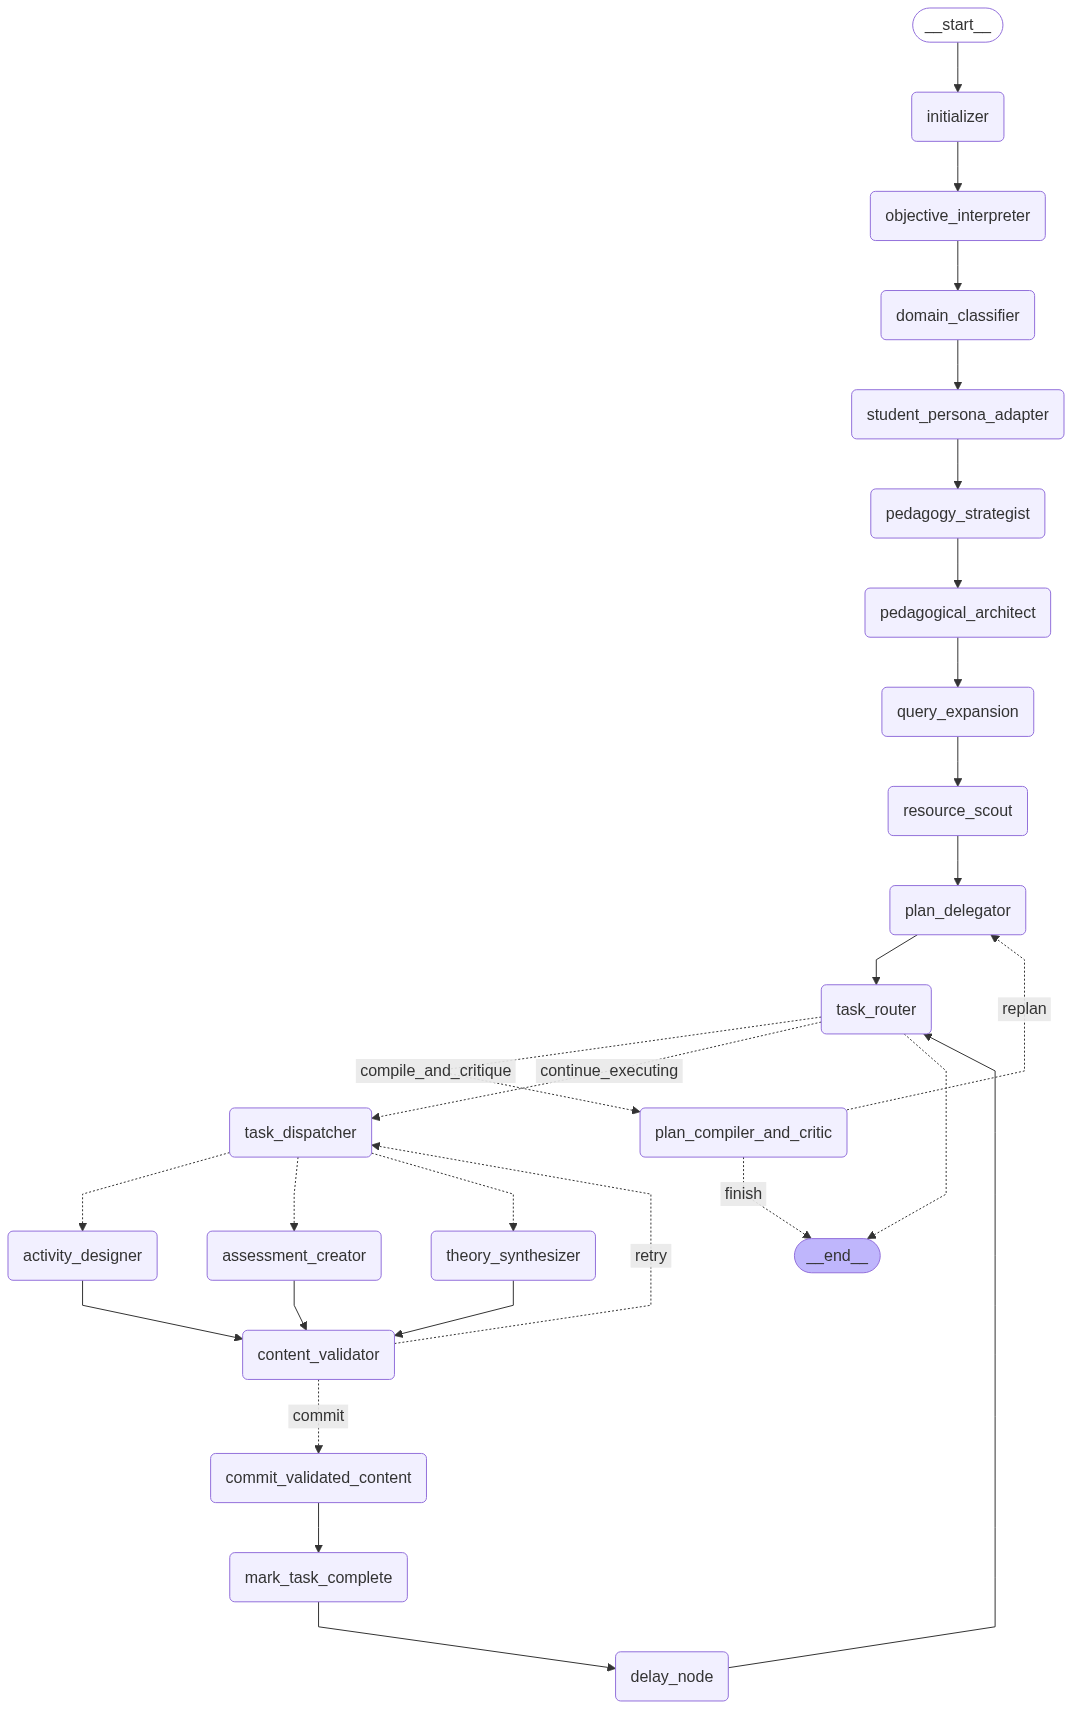

In [ ]:
# ==============================================================================
# CELL 4.4: HIỂN THỊ SƠ ĐỒ GRAPH (TÙY CHỌN)
# ==============================================================================
try:
    # Lệnh này sẽ vẽ một sơ đồ của workflow, rất hữu ích để gỡ lỗi
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Lỗi vẽ biểu đồ: {e}. Đây là lỗi không nghiêm trọng, bạn vẫn có thể chạy quy trình.")

## PHẦN 5

In [ ]:
# ==============================================================================
# CELL 5.1: ĐỊNH NGHĨA HÀM CHẠY QUY TRÌNH
# ==============================================================================
async def run_architect(user_request: str):
    if 'llm' not in globals() or llm is None:
        print_warning("LLM chưa được khởi tạo. Vui lòng chạy lại Cell 1.3.")
        return
    if 'vector_store' not in globals() or vector_store is None:
        print_warning("Kho tri thức chưa được tải. Vui lòng chạy lại Cell 1.4.")
        return
    if 'app' not in globals():
        print_warning("Graph 'app' chưa được biên dịch. Vui lòng chạy lại Cell 4.3.")
        return

    initial_state = {"messages": [HumanMessage(content=user_request)]}
    console.print(f"\n[bold magenta]🚀 BẮT ĐẦU QUY TRÌNH V7.1 (THE ARCHITECT) VỚI YÊU CẦU:[/bold magenta]\n> {user_request}")
    config = {"recursion_limit": 150} 
    
    final_state_result = None
    try:
        async for event in app.astream(initial_state, config=config):
            for node_name, node_output in event.items():
                console.print(f"\n[bold yellow]------- Hoàn thành bước: {node_name} -------[/bold yellow]")
                final_state_result = node_output

        console.print("\n[bold magenta]🏁 KẾT THÚC QUY TRÌNH V7.1.[/bold magenta]")
        
        if final_state_result and final_state_result.get("final_markdown_plan"):
            console.print("\n[bold green]📝 GIÁO ÁN HOÀN CHỈNH (v9.0)[/bold green]")
            console.print(Markdown(final_state_result["final_markdown_plan"]))
            
            # (Tùy chọn) In ra cả JSON để kiểm tra
            if VERBOSE_MODE:
                print_result(final_state_result.get("final_structured_plan"), "Output JSON có cấu trúc")

        else:
            print_warning("Không tạo được giáo án cuối cùng. Có thể Critic đã yêu cầu làm lại nhưng hết giới hạn đệ quy.")
            print("\nTrạng thái cuối cùng để gỡ lỗi:")
            pprint(final_state_result)
            
    except Exception as e:
        print_warning(f"Đã xảy ra lỗi nghiêm trọng trong quá trình chạy graph: {e}")
        import traceback
        traceback.print_exc()

print("✅ Hàm `run_architect` đã sẵn sàng để sử dụng.")

✅ Hàm `run_architect` đã sẵn sàng để sử dụng.


In [ ]:
# ==============================================================================
# CELL 5.2: KÍCH HOẠT CHẠY THỬ NGHIỆM
# ==============================================================================
# Yêu cầu để kiểm tra
architect_request = "Soạn giúp tôi giáo án bài 'Đường tròn ngoại tiếp và đường tròn nội tiếp' cho học sinh lớp 9 trong 90 phút. Đây là một lớp học khá yếu, các em thường mất tập trung và cần các hoạt động có tính tương tác cao."
VERBOSE_MODE = True 

# Chạy quy trình đã được cải cách
# Lưu ý: bạn cần một môi trường hỗ trợ `await` ở cấp độ cao nhất (như Jupyter Notebook)
await run_architect(architect_request)

🚀 BẮT ĐẦU QUY TRÌNH V7.1 (THE ARCHITECT) VỚI YÊU CẦU:
> Soạn giúp tôi giáo án bài 'Đường tròn ngoại tiếp và đường tròn nội tiếp' cho học sinh lớp 9 trong 90 phút. Đây là
một lớp học khá yếu, các em thường mất tập trung và cần các hoạt động có tính tương tác cao.

> `Initializer`: Đang khởi tạo trạng thái và lấy yêu cầu gốc...

------- Hoàn thành bước: initializer -------

> `Agent: Objective Interpreter` (v7.5) đang phân tích mục tiêu...

✔️ Mục tiêu & Ràng buộc đã phân tích:

{
│   'action_verb': 'thiết kế',
│   'bloom_level': 2,
│   'topic': 'Đường tròn ngoại tiếp và đường tròn nội tiếp',
│   'grade_level': 'lớp 9',
│   'constraints': {
│   │   'duration_minutes': 90
│   }
}

------- Hoàn thành bước: objective_interpreter -------

> `Agent: Domain Classifier` (v7.5) đang xác định lĩnh vực chuyên môn...

✔️ Lĩnh vực chuyên môn được xác định:

'Toán học'

------- Hoàn thành bước: domain_classifier -------

> `Agent: Student Persona Adapter` (v7.5) đang phân tích đặc điểm lớp học...

✔️ Hồ sơ lớp học đã được phân tích:

{
│   'learning_pace': 'chậm',
│   'engagement_style': 'chủ động',
│   'special_notes': 'Lớp học khá yếu, học sinh dễ mất tập trung và cần các hoạt động tương tác cao.'
}

------- Hoàn thành bước: student_persona_adapter -------

> `Agent: Pedagogy Strategist` (v7.5) đang xây dựng chiến lược sư phạm chi tiết...

✔️ Chiến lược sư phạm chi tiết:

{
│   'name': 'Dạy học hợp tác kết hợp thực hành',
│   'rationale': "Phương pháp này rất phù hợp với lớp học có tốc độ học chậm, dễ mất tập trung và cần tương tác cao. Việc chia nhóm và giao nhiệm vụ thực hành cụ thể giúp học sinh chủ động tham gia, hỗ trợ lẫn nhau, duy trì sự tập trung và củng cố kiến thức thông qua việc 'thiết kế' trực tiếp. Hoạt động thực hành cũng giúp biến kiến thức hình học trừu tượng thành trải nghiệm cụ thể, dễ hiểu hơn, đồng thời phát huy tính chủ động và khả năng làm việc nhóm của học sinh.",
│   'key_actions': [
│   │   'Giới thiệu nhiệm vụ thực hành/vấn đề cụ thể liên quan đến đường tròn ngoại tiếp và nội tiếp (ví dụ: thiết kế vị trí đài phun nước trong sân vườn hình tam giác)',
│   │   'Chia học sinh thành các nhóm nhỏ (3-4 em) và phân công vai trò rõ ràng trong nhóm',
│   │   'Cung cấp vật liệu cần thiết (thước, compa, giấy) và hướng dẫn ban đầu về cách thực hiện nhiệm vụ',
│   │   'Học sinh làm việc nhóm, cùng nhau thực hành vẽ/thiết kế, thảo luận và giải quyết vấn đề',
│   │   'Giáo viên quan sát, hỗ trợ, gợi mở và giải đáp thắc mắc cho từng nhóm',
│   │   'Các nhóm trình bày sản phẩm/kết quả thực hành của mình trước lớp',
│   │   'Cả lớp cùng thảo luận, nhận xét và giáo viên tổng kết, chốt lại kiến thức trọng tâm'
│   ]
}

------- Hoàn thành bước: pedagogy_strategist -------

> `Agent: Pedagogical Architect` (v7.5) đang thiết kế kịch bản buổi học...

✔️ Bản thiết kế Sư phạm đã được tạo:

[
│   'Giai đoạn 1: Khơi gợi và Đặt vấn đề: Giáo viên giới thiệu một tình huống thực tế gần gũi (ví dụ: thiết kế vị trí đài phun nước trong sân vườn hình tam giác, hoặc đặt cột cờ ở trung tâm sân trường hình tam giác) để khơi gợi vấn đề, tạo sự tò mò và kết nối kiến thức cũ (tâm đường tròn) với kiến thức mới. Khuyến khích học sinh đặt câu hỏi và chia sẻ ý tưởng ban đầu.',
│   "Giai đoạn 2: Khám phá và Xây dựng kiến thức: Giáo viên chia học sinh thành các nhóm nhỏ (3-4 em), phát vật liệu cần thiết (giấy, thước, compa, kéo) và giao nhiệm vụ thực hành cụ thể. Ví dụ: 'Hãy vẽ một tam giác bất kỳ, sau đó tìm cách vẽ một đường tròn đi qua ba đỉnh của tam giác đó' và 'Hãy vẽ một tam giác khác, sau đó tìm cách vẽ một đường tròn tiếp xúc với cả ba cạnh của tam giác đó'. Giáo viên quan sát, gợi mở, hỗ trợ các nhóm trong quá trình thực hành, thảo luận và ghi nhận các phát hiện ban đầu của học sinh.",
│   'Giai đoạn 3: Vận dụng và Củng cố: Các nhóm trình bày sản phẩm/kết quả thực hành của mình trước lớp, giải thích cách làm và những phát hiện của nhóm. Giáo viên đặt câu hỏi gợi mở để các nhóm và cả lớp cùng thảo luận, nhận xét, so sánh các cách làm. Giáo viên chốt lại kiến thức trọng tâm về định nghĩa, tính chất của tâm và bán kính đường tròn ngoại tiếp/nội tiếp, đồng thời đưa ra một số bài tập vận dụng nhỏ để học sinh thực hành cá nhân hoặc theo cặp.',
│   'Giai đoạn 4: Tổng kết và Mở rộng: Giáo viên tổng kết lại toàn bộ kiến thức trọng tâm của buổi học, nhấn mạnh các điểm cần lưu ý, các lỗi thường gặp và mối liên hệ giữa đường tròn ngoại tiếp/nội tiếp với các dạng tam giác đặc biệt. Giải đáp các thắc mắc cuối cùng của học sinh. Giao bài tập về nhà để học sinh tự luyện tập và mở rộng kiến thức, khuyến khích các em tìm thêm các ứng dụng thực tế khác của đường tròn ngoại tiếp và nội tiếp.'
]

------- Hoàn thành bước: pedagogical_architect -------

> `Agent: Query Expansion` (v7.5) đang phân tích yêu cầu...

✔️ Các truy vấn tìm kiếm đã được mở rộng:

[
│   'đường tròn ngoại tiếp và đường tròn nội tiếp',
│   'công thức đường tròn ngoại tiếp tam giác',
│   'tính chất đường tròn nội tiếp tứ giác',
│   'bài tập đường tròn ngoại tiếp lớp 9',
│   'lý thuyết đường tròn nội tiếp và ngoại tiếp',
│   'cách xác định tâm đường tròn ngoại tiếp',
│   'bán kính đường tròn nội tiếp tam giác vuông',
│   'chuyên đề đường tròn ngoại tiếp nội tiếp ôn thi',
│   'ứng dụng đường tròn ngoại tiếp trong hình học',
│   'phân biệt đường tròn nội tiếp và ngoại tiếp',
│   'đường tròn ngoại tiếp đa giác đều',
│   'bài tập nâng cao đường tròn nội tiếp',
│   'mối liên hệ giữa đường tròn nội tiếp và ngoại tiếp',
│   'công thức tính diện tích tam giác qua bán kính đường tròn nội tiếp',
│   'đường tròn ngoại tiếp tứ giác nội tiếp'
]

------- Hoàn thành bước: query_expansion -------

> `Agent: Resource Scout` (v8.1 - Sửa lỗi) đang tìm kiếm và sàng lọc...

> Tìm thấy 75 tài liệu, sàng lọc còn 8 đoạn văn bản độc nhất.

✔️ Tài liệu RAG cuối cùng:

{
│   'source': 'Sách giáo khoa (từ RAG - đã sàng lọc)',
│   'summary': 'Chào các em học sinh,\n\nVới vai trò là một giáo viên giàu kinh nghiệm, thầy/cô sẽ tổng hợp kiến thức cốt lõi từ các đoạn văn bản mà các em đã cung cấp.\n\n**TÓM TẮT KIẾN THỨC CỐT LÕI VỀ ĐƯỜNG TRÒN (LIÊN QUAN ĐẾN TAM GIÁC VÀ CÁC KHÁI NIỆM CHUNG)**\n\nKính chào các em học sinh. Dựa trên các đoạn văn bản được cung cấp, thầy/cô nhận thấy rằng các khái niệm "đường tròn ngoại tiếp" và "đường tròn nội tiếp" không được định nghĩa trực tiếp. Tuy nhiên, văn bản có đề cập đến một số tính chất và trường hợp đặc biệt của đường tròn có liên quan đến tam giác, cùng với các kiến thức cơ bản về đường tròn.\n\nDưới đây là bản tóm tắt các kiến thức cốt lõi được suy luận từ các đoạn văn bản:\n\n**1. Đường tròn và Tam giác:**\n\n*   **1.1. Đường tròn đi qua các đỉnh của tam giác:**\n    *   Nếu một tam giác có các đỉnh nằm trên một đường tròn và một cạnh của tam giác là đường kính của đường tròn đó, thì tam giác đó là tam giác vuông tại đỉnh đối diện với cạnh đường kính. Ngược lại, nếu một tam giác là tam giác vuông, thì đường tròn có đường kính là cạnh huyền của tam giác đó sẽ đi qua cả ba đỉnh của tam giác (Bài 5.36a).\n    *   Đường tròn có đường kính là một cạnh của tam giác có thể đi qua các chân đường cao kẻ từ hai đỉnh còn lại của tam giác đó (Ví dụ 1a).\n\n**2. Vị trí tương đối của đường thẳng và đường tròn:**\n\n*   **2.1. Định nghĩa:**\n    *   **Cắt nhau:** Đường thẳng và đường tròn có đúng hai điểm chung.\n    *   **Tiếp xúc với nhau:** Đường thẳng và đường tròn có đúng một điểm chung. Điểm chung này gọi là **tiếp điểm**, và đường thẳng được gọi là **tiếp tuyến** của đường tròn tại tiếp điểm đó.\n    *   **Không giao nhau:** Đường thẳng và đường tròn không có điểm chung nào.\n*   **2.2. Dấu hiệu nhận biết:** Gọi $d$ là khoảng cách từ tâm $O$ của đường tròn đến đường thẳng $a$, và $R$ là bán kính của đường tròn $(O; R)$.\n    *   Đường thẳng $a$ và đường tròn $(O; R)$ cắt nhau khi $d < R$.\n    *   Đường thẳng $a$ và đường tròn $(O; R)$ tiếp xúc với nhau khi $d = R$.\n    *   Đường thẳng $a$ và đường tròn $(O; R)$ không giao nhau khi $d > R$.\n*   **2.3. Dấu hiệu nhận biết tiếp tuyến của đường tròn:** Nếu một đường thẳng đi qua một điểm trên một đường tròn và vuông góc với bán kính đi qua điểm đó, thì đường thẳng ấy là một tiếp tuyến của đường tròn (Định lí 1).\n\n**3. Vị trí tương đối của hai đường tròn:**\n\n*   Cho hai đường tròn $(O; R)$ và $(O\'; R\')$ với $R \\geq R\'$.\n*   **Hai đường tròn cắt nhau:** Có 2 điểm chung. Hệ thức giữa khoảng cách $OO\'$ và bán kính: $R - R\' < OO\' < R + R\'$.\n*   **Hai đường tròn tiếp xúc nhau:** Có 1 điểm chung.\n    *   **Tiếp xúc ngoài:** Khoảng cách giữa hai tâm bằng tổng hai bán kính: $OO\' = R + R\'$.\n    *   **Tiếp xúc trong:** Khoảng cách giữa hai tâm bằng hiệu hai bán kính (lớn trừ bé): $OO\' = R - R\' > 0$.\n*   **Hai đường tròn không giao nhau:** Không có điểm chung.\n    *   **Hai đường tròn ở ngoài nhau:** Khoảng cách giữa hai tâm lớn hơn tổng hai bán kính: $OO\' > R + R\'$.\n    *   **Một đường tròn đựng đường tròn kia (đồng tâm hoặc không đồng tâm):** Khoảng cách giữa hai tâm nhỏ hơn hiệu hai bán kính: $OO\' < R - R\'$.\n\n**4. Các khái niệm và công thức tính toán liên quan đến đường tròn:**\n\n*   **Cung tròn:** Là một phần của đường tròn. Có cung nhỏ và cung lớn.\n*   **Độ dài cung:** Có thể tính được khi biết bán kính và số đo cung (Bài 5.9b, 5.36c, 5.37b).\n*   **Hình quạt tròn:** Là phần hình tròn giới hạn bởi hai bán kính và cung tròn.\n*   **Diện tích hình quạt tròn:** Có thể tính được khi biết bán kính và số đo cung (Bài 5.10, 5.12, 5.13, 5.36c, 5.37b).\n*   **Hình vành khuyên:** Là phần nằm giữa hai đường tròn đồng tâm.\n*   **Diện tích hình vành khuyên:** Có thể tính được khi biết bán kính của hai đường tròn đồng tâm (Bài 5.11).\n\nHy vọng bản tóm tắt này giúp các em nắm vững các kiến thức cơ bản về đường tròn từ các bài tập và ví dụ đã cho.'
}

------- Hoàn thành bước: resource_scout -------

> `Agent: Plan Delegator` (v8.2 - Siêu cụ thể) đang triển khai Bản thiết kế...

✔️ Đã tạo 5 nhiệm vụ chi tiết:

[
│   {
│   │   'task_id': 0,
│   │   'task_name': 'Ôn tập kiến thức nền tảng về hình học',
│   │   'task_description': 'Học sinh ôn tập và trình bày lại các khái niệm cơ bản về đường tròn, tam giác, và các loại đường đặc biệt trong tam giác (đường trung trực, đường phân giác) thông qua việc trả lời câu hỏi và vẽ minh họa.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 1,
│   │   'task_name': 'Khám phá và định nghĩa Đường tròn ngoại tiếp',
│   │   'task_description': 'Học sinh thực hiện vẽ hình một tam giác bất kỳ, sau đó xác định giao điểm của ba đường trung trực của các cạnh để tìm tâm đường tròn ngoại tiếp và vẽ đường tròn đi qua ba đỉnh của tam giác. Từ đó, học sinh nêu định nghĩa và các tính chất cơ bản của đường tròn ngoại tiếp.',
│   │   'estimated_duration': 25,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 2,
│   │   'task_name': 'Vận dụng kiến thức về Đường tròn ngoại tiếp',
│   │   'task_description': 'Học sinh giải các bài tập thực hành liên quan đến việc xác định tâm, bán kính đường tròn ngoại tiếp của các loại tam giác khác nhau (vuông, cân, đều) và chứng minh các tính chất liên quan đến đường tròn ngoại tiếp tứ giác nội tiếp.',
│   │   'estimated_duration': 20,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 3,
│   │   'task_name': 'Khám phá và định nghĩa Đường tròn nội tiếp',
│   │   'task_description': 'Học sinh thực hiện vẽ hình một tam giác bất kỳ, sau đó xác định giao điểm của ba đường phân giác của các góc để tìm tâm đường tròn nội tiếp và vẽ đường tròn tiếp xúc với ba cạnh của tam giác. Từ đó, học sinh nêu định nghĩa và các tính chất cơ bản của đường tròn nội tiếp.',
│   │   'estimated_duration': 25,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 4,
│   │   'task_name': 'Vận dụng Đường tròn nội tiếp và tổng kết kiến thức',
│   │   'task_description': 'Học sinh giải các bài tập thực hành liên quan đến việc xác định tâm, bán kính đường tròn nội tiếp của tam giác. Sau đó, học sinh so sánh điểm giống và khác nhau giữa đường tròn ngoại tiếp và đường tròn nội tiếp, hệ thống hóa kiến thức đã học.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   }
]

------- Hoàn thành bước: plan_delegator -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Ôn tập kiến thức nền tảng về hình học' (ID: 0)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `theory_synthesizer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Theory Synthesizer` (v8.0) đang tạo nội dung chi tiết...

✔️ Nội dung do Theory Synthesizer tạo ra:

{
│   'activity_name': 'Ôn tập kiến thức nền tảng về hình học',
│   'description': 'Học sinh sẽ nhận phiếu bài tập cá nhân. Trên phiếu có các câu hỏi và yêu cầu vẽ hình minh họa về các khái niệm cơ bản của hình học liên quan đến đường tròn và tam giác. Cụ thể, học sinh sẽ: 1. Định nghĩa đường tròn, tâm, bán kính, dây cung, đường kính. 2. Nêu các loại tam giác cơ bản (đều, cân, vuông) và đặc điểm của chúng. 3. Định nghĩa và vẽ minh họa đường trung trực của đoạn thẳng. 4. Định nghĩa và vẽ minh họa đường phân giác của góc. Học sinh hoàn thành phiếu bài tập trong thời gian quy định.',
│   'duration_minutes': 10,
│   'activity_type': 'Ôn tập cá nhân',
│   'teacher_actions': [
│   │   'Chiếu slide giới thiệu hoạt động "Ôn tập kiến thức nền tảng về hình học" và mục tiêu của hoạt động.',
│   │   'Phát phiếu bài tập "Ôn tập kiến thức nền tảng" cho từng học sinh.',
│   │   'Nhắc nhở học sinh đọc kỹ yêu cầu và hoàn thành bài tập cá nhân.',
│   │   'Quan sát học sinh làm bài, đi lại trong lớp để nắm bắt tình hình và kịp thời hỗ trợ.',
│   │   'Gợi ý, hỗ trợ những học sinh gặp khó khăn (ví dụ: "Em thử nhớ lại định nghĩa đường trung trực là gì?", "Đường phân giác có tính chất gì đặc biệt?").',
│   │   'Thu phiếu bài tập sau khi hết giờ.'
│   ],
│   'solution_guide': [
│   │   'Câu 1: Hãy định nghĩa đường tròn, tâm, bán kính, dây cung, đường kính và vẽ hình minh họa một đường tròn với các yếu tố đó.',
│   │   'Câu 2: Nêu tên và đặc điểm của ba loại tam giác cơ bản (tam giác đều, tam giác cân, tam giác vuông). Vẽ hình minh họa cho mỗi loại.',
│   │   'Câu 3: Đường trung trực của một đoạn thẳng là gì? Vẽ một đoạn thẳng AB và đường trung trực của nó.',
│   │   'Câu 4: Đường phân giác của một góc là gì? Vẽ một góc xOy và đường phân giác của góc đó.'
│   ]
}

------- Hoàn thành bước: theory_synthesizer -------

> `Agent: Contextual Critic` (v7.5) đang phản biện nội dung...

> ✔️ CHUYÊN GIA PHẢN BIỆN: Nội dung hợp lệ!

> ROUTER (Validation): Nội dung được chấp thuận. Chuyển sang bước ghi nhận.

------- Hoàn thành bước: content_validator -------

> `Commiter`: Đang ghi nhận nội dung đã được xác thực...

------- Hoàn thành bước: commit_validated_content -------

------- Hoàn thành bước: mark_task_complete -------

> ...Đang nghỉ 2 giây để tránh vượt rate limit...

------- Hoàn thành bước: delay_node -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Khám phá và định nghĩa Đường tròn ngoại tiếp' (ID: 1)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v8.0) đang tạo nội dung chi tiết...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khám phá và định nghĩa Đường tròn ngoại tiếp',
│   'description': 'Học sinh thực hiện các bước sau:\n1. Vẽ một tam giác bất kỳ (ví dụ: tam giác ABC) vào vở hoặc giấy A4.\n2. Dùng thước và compa để vẽ ba đường trung trực của ba cạnh của tam giác đó.\n3. Xác định giao điểm của ba đường trung trực. Gọi điểm đó là O.\n4. Dùng compa vẽ đường tròn tâm O đi qua ba đỉnh của tam giác.\n5. Thảo luận nhóm (2-3 học sinh) để nêu định nghĩa đường tròn ngoại tiếp tam giác và các tính chất cơ bản của nó (ví dụ: vị trí của tâm đường tròn ngoại tiếp đối với các loại tam giác nhọn, vuông, tù).',
│   'duration_minutes': 25,
│   'activity_type': 'Hoạt động thực hành và khám phá',
│   'teacher_actions': [
│   │   'Phát giấy A4 và yêu cầu học sinh chuẩn bị thước, compa.',
│   │   'Chiếu slide hướng dẫn các bước vẽ hình (vẽ tam giác, vẽ đường trung trực, xác định giao điểm, vẽ đường tròn).',
│   │   'Đi lại quan sát các nhóm thực hiện, kịp thời hỗ trợ những học sinh gặp khó khăn trong việc vẽ đường trung trực và xác định tâm.',
│   │   "Gợi ý các câu hỏi để học sinh thảo luận và rút ra định nghĩa, tính chất (sử dụng các câu hỏi trong phần 'solution_guide').",
│   │   'Yêu cầu đại diện một số nhóm trình bày kết quả vẽ hình và định nghĩa, tính chất đã rút ra.',
│   │   'Chốt lại định nghĩa và các tính chất quan trọng của đường tròn ngoại tiếp tam giác.'
│   ],
│   'solution_guide': [
│   │   'Giao điểm của ba đường trung trực có vị trí đặc biệt gì so với ba đỉnh của tam giác?',
│   │   'Đường tròn vừa vẽ có đặc điểm gì liên quan đến tam giác?',
│   │   'Từ đó, em hãy định nghĩa đường tròn ngoại tiếp tam giác.',
│   │   'Tâm của đường tròn ngoại tiếp nằm ở đâu đối với các loại tam giác khác nhau (tam giác nhọn, tam giác vuông, tam giác tù)?'
│   ]
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Contextual Critic` (v7.5) đang phản biện nội dung...

> ✔️ CHUYÊN GIA PHẢN BIỆN: Nội dung hợp lệ!

> ROUTER (Validation): Nội dung được chấp thuận. Chuyển sang bước ghi nhận.

------- Hoàn thành bước: content_validator -------

> `Commiter`: Đang ghi nhận nội dung đã được xác thực...

------- Hoàn thành bước: commit_validated_content -------

------- Hoàn thành bước: mark_task_complete -------

> ...Đang nghỉ 2 giây để tránh vượt rate limit...

------- Hoàn thành bước: delay_node -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Vận dụng kiến thức về Đường tròn ngoại tiếp' (ID: 2)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v8.0) đang tạo nội dung chi tiết...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Vận dụng kiến thức về Đường tròn ngoại tiếp',
│   'description': 'Học sinh sẽ giải các bài tập thực hành để củng cố kiến thức về đường tròn ngoại tiếp. Các bài tập bao gồm:\n\nBài 1: Cho tam giác ABC vuông tại A có AB = 6cm, AC = 8cm. Hãy xác định tâm và tính bán kính đường tròn ngoại tiếp tam giác ABC.\n\nBài 2: Cho tam giác đều ABC cạnh 6cm. Hãy xác định tâm và tính bán kính đường tròn ngoại tiếp tam giác ABC.\n\nBài 3: Cho tứ giác ABCD nội tiếp đường tròn. Biết góc A = 75 độ, góc B = 100 độ. Hãy tính số đo góc C và góc D.',
│   'duration_minutes': 20,
│   'activity_type': 'Luyện tập',
│   'teacher_actions': [
│   │   'Chiếu đề bài tập lên màn hình hoặc phát phiếu bài tập cho học sinh.',
│   │   'Nhắc lại ngắn gọn các kiến thức trọng tâm về tâm đường tròn ngoại tiếp của tam giác vuông, tam giác đều và tính chất góc của tứ giác nội tiếp.',
│   │   'Quan sát học sinh làm bài, đi lại trong lớp để nắm bắt tình hình và kịp thời hỗ trợ.',
│   │   "Gợi ý, đặt câu hỏi dẫn dắt khi học sinh gặp khó khăn (ví dụ: 'Tâm đường tròn ngoại tiếp tam giác vuông nằm ở đâu?', 'Tính chất góc của tứ giác nội tiếp là gì?').",
│   │   'Gọi 2-3 học sinh lên bảng trình bày lời giải các bài tập.',
│   │   'Chữa bài tập và chốt lại các kiến thức quan trọng sau khi học sinh đã hoàn thành.'
│   ],
│   'solution_guide': [
│   │   'Bài 1: Tâm đường tròn ngoại tiếp tam giác vuông là trung điểm cạnh huyền. Bán kính bằng nửa cạnh huyền. (Cạnh huyền BC = 10cm, R = 5cm).',
│   │   'Bài 2: Tâm đường tròn ngoại tiếp tam giác đều là giao điểm của ba đường trung trực (cũng là trọng tâm, trực tâm, tâm đường tròn nội tiếp). Bán kính R = a/√3 (với a là cạnh tam giác). (R = 6/√3 = 2√3 cm).',
│   │   'Bài 3: Trong tứ giác nội tiếp, tổng hai góc đối diện bằng 180 độ. (Góc C = 180 - 75 = 105 độ; Góc D = 180 - 100 = 80 độ).'
│   ]
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Contextual Critic` (v7.5) đang phản biện nội dung...

> ✔️ CHUYÊN GIA PHẢN BIỆN: Nội dung hợp lệ!

> ROUTER (Validation): Nội dung được chấp thuận. Chuyển sang bước ghi nhận.

------- Hoàn thành bước: content_validator -------

> `Commiter`: Đang ghi nhận nội dung đã được xác thực...

------- Hoàn thành bước: commit_validated_content -------

------- Hoàn thành bước: mark_task_complete -------

> ...Đang nghỉ 2 giây để tránh vượt rate limit...

------- Hoàn thành bước: delay_node -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Khám phá và định nghĩa Đường tròn nội tiếp' (ID: 3)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v8.0) đang tạo nội dung chi tiết...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Khám phá và định nghĩa Đường tròn nội tiếp',
│   'description': 'Học sinh thực hiện các bước sau: 1. Vẽ một tam giác ABC bất kỳ lên giấy. 2. Dùng thước và compa để vẽ ba đường phân giác của ba góc A, B, C của tam giác. 3. Xác định giao điểm của ba đường phân giác đó (điểm I). Điểm I chính là tâm của đường tròn nội tiếp. 4. Từ tâm I, vẽ đường tròn tiếp xúc với ba cạnh của tam giác. 5. Dựa trên hình vẽ và quá trình thực hiện, hãy nêu định nghĩa về đường tròn nội tiếp tam giác và liệt kê các tính chất cơ bản của nó.',
│   'duration_minutes': 25,
│   'activity_type': 'Thực hành và khám phá',
│   'teacher_actions': [
│   │   'Kiểm tra sự chuẩn bị dụng cụ học tập (thước, compa) của học sinh.',
│   │   'Chiếu slide hướng dẫn các bước vẽ đường phân giác nếu cần thiết.',
│   │   'Đi lại quan sát các nhóm/cá nhân thực hiện, kịp thời hỗ trợ những học sinh gặp khó khăn trong việc vẽ hình hoặc xác định tâm.',
│   │   "Đặt câu hỏi gợi mở: 'Làm thế nào để biết đường tròn đã tiếp xúc với ba cạnh?', 'Khoảng cách từ tâm I đến các cạnh có gì đặc biệt?'",
│   │   'Yêu cầu một vài học sinh/nhóm trình bày kết quả vẽ hình và định nghĩa, tính chất đã tìm được.',
│   │   'Tổng kết và chốt kiến thức về định nghĩa và tính chất của đường tròn nội tiếp.'
│   ],
│   'solution_guide': [
│   │   'Câu hỏi gợi mở 1: Ba đường phân giác của một tam giác có đặc điểm gì về giao điểm của chúng?',
│   │   'Câu hỏi gợi mở 2: Khoảng cách từ tâm I (giao điểm của ba đường phân giác) đến ba cạnh của tam giác có mối quan hệ như thế nào?',
│   │   'Câu hỏi gợi mở 3: Dựa vào mối quan hệ đó, em hãy định nghĩa đường tròn nội tiếp tam giác.',
│   │   'Câu hỏi gợi mở 4: Đường tròn nội tiếp có những tính chất cơ bản nào liên quan đến tâm và bán kính của nó?'
│   ]
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Contextual Critic` (v7.5) đang phản biện nội dung...

> ✔️ CHUYÊN GIA PHẢN BIỆN: Nội dung hợp lệ!

> ROUTER (Validation): Nội dung được chấp thuận. Chuyển sang bước ghi nhận.

------- Hoàn thành bước: content_validator -------

> `Commiter`: Đang ghi nhận nội dung đã được xác thực...

------- Hoàn thành bước: commit_validated_content -------

------- Hoàn thành bước: mark_task_complete -------

> ...Đang nghỉ 2 giây để tránh vượt rate limit...

------- Hoàn thành bước: delay_node -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Vận dụng Đường tròn nội tiếp và tổng kết kiến thức' (ID: 4)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v8.0) đang tạo nội dung chi tiết...

✔️ Nội dung do Activity Designer tạo ra:

{
│   'activity_name': 'Vận dụng Đường tròn nội tiếp và tổng kết kiến thức',
│   'description': 'Học sinh sẽ thực hiện các nhiệm vụ sau:1. Giải bài tập thực hành: Bài 1: Cho tam giác ABC vuông tại A có AB = 6cm, AC = 8cm. Tính bán kính đường tròn nội tiếp tam giác ABC. Bài 2: Nêu cách xác định tâm đường tròn nội tiếp của một tam giác bất kỳ bằng thước và compa.2. So sánh và tổng kết kiến thức: Lập bảng so sánh điểm giống và khác nhau giữa đường tròn ngoại tiếp và đường tròn nội tiếp của một tam giác (về định nghĩa, vị trí tâm, cách xác định tâm, công thức tính bán kính). Thảo luận nhóm để hệ thống hóa các kiến thức quan trọng nhất về hai loại đường tròn này.',
│   'duration_minutes': 10,
│   'activity_type': 'Luyện tập và Tổng kết',
│   'teacher_actions': [
│   │   'Chiếu slide chứa các bài tập thực hành và yêu cầu so sánh.',
│   │   'Phát phiếu học tập có in sẵn đề bài và bảng so sánh cho từng nhóm hoặc cá nhân.',
│   │   'Đi lại quan sát các nhóm làm việc, gợi ý và hỗ trợ khi học sinh gặp khó khăn.',
│   │   "Đặt câu hỏi gợi mở: 'Tâm đường tròn nội tiếp là giao điểm của những đường nào?', 'Công thức tính bán kính đường tròn nội tiếp tam giác vuông là gì?', 'Điểm khác biệt lớn nhất giữa tâm đường tròn nội tiếp và ngoại tiếp là gì?'",
│   │   'Yêu cầu đại diện 1-2 nhóm trình bày kết quả bài tập và bảng so sánh trên bảng hoặc qua máy chiếu.',
│   │   'Tổng kết các kiến thức trọng tâm về đường tròn nội tiếp và ngoại tiếp, nhấn mạnh các điểm cần lưu ý và các lỗi thường gặp.'
│   ],
│   'solution_guide': {
│   │   'Gợi ý Bài 1': 'Sử dụng công thức tính bán kính đường tròn nội tiếp tam giác vuông r = (a+b-c)/2 hoặc công thức diện tích S = pr.',
│   │   'Gợi ý Bài 2': 'Tâm đường tròn nội tiếp là giao điểm của ba đường phân giác trong của tam giác.',
│   │   'Gợi ý so sánh': 'Tập trung vào định nghĩa, vị trí tâm (trong/ngoài tam giác), cách xác định tâm (giao điểm của đường gì), và công thức tính bán kính (nếu có).',
│   │   'Câu hỏi tổng kết': 'Khi nào thì tâm đường tròn ngoại tiếp nằm ngoài tam giác? Khi nào thì tâm đường tròn nội tiếp trùng với tâm đường tròn ngoại tiếp?'
│   }
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Contextual Critic` (v7.5) đang phản biện nội dung...

> ✔️ CHUYÊN GIA PHẢN BIỆN: Nội dung hợp lệ!

> ROUTER (Validation): Nội dung được chấp thuận. Chuyển sang bước ghi nhận.

------- Hoàn thành bước: content_validator -------

> `Commiter`: Đang ghi nhận nội dung đã được xác thực...

------- Hoàn thành bước: commit_validated_content -------

------- Hoàn thành bước: mark_task_complete -------

> ...Đang nghỉ 2 giây để tránh vượt rate limit...

------- Hoàn thành bước: delay_node -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Hết nhiệm vụ, chuyển sang node Compiler & Critic.

------- Hoàn thành bước: task_router -------

> `Agent: Plan Compiler & Critic` (v8.0) đang tổng hợp và đánh giá...

> CRITIC: Kế hoạch hợp lệ! Bắt đầu tổng hợp giáo án chi tiết...

> ✔️ Đã biên tập thành công giáo án cuối cùng với lời chuyển mượt mà.

> ROUTER (Compilation): Critic lớn đã hài lòng. Kết thúc quy trình.

------- Hoàn thành bước: plan_compiler_and_critic -------

🏁 KẾT THÚC QUY TRÌNH V7.1.

📝 GIÁO ÁN HOÀN CHỈNH (v7.1)

Chào các em học sinh,                                                                                              

Với vai trò là một Biên tập viên Sư phạm giàu kinh nghiệm, thầy/cô đã tiếp nhận thông tin tổng quan và bản nháp chi
tiết các hoạt động của buổi học. Dựa trên những thông tin này, thầy/cô xin trình bày một Giáo án hoàn chỉnh dưới   
đây, đảm bảo tuân thủ mọi quy tắc đã đề ra.                                                                        

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                                             GIÁO ÁN MÔN TOÁN LỚP 9                                              ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛


                                 BÀI: ĐƯỜNG TRÒN NGOẠI TIẾP VÀ ĐƯỜNG TRÒN NỘI TIẾP                                 

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                I. THÔNG TIN CHUNG                                                 

 • Môn học: Toán học                                                                                               
 • Lớp: 9                                                                                                          
 • Thời lượng: 90 phút                                                                                             
 • Chủ đề: Đường tròn ngoại tiếp và đường tròn nội tiếp                                                            
 • Phương pháp chủ đạo: Dạy học hợp tác kết hợp thực hành                                                          
 • Đặc điểm lớp học: Lớp học khá yếu, học sinh dễ mất tập trung và cần các hoạt động tương tác cao.                

                                               II. MỤC TIÊU BÀI HỌC                                                

Sau khi hoàn thành bài học này, học sinh có thể:                                                                   

 1 Kiến thức:                                                                                                      
    • Nêu được định nghĩa đường tròn ngoại tiếp tam giác và đường tròn nội tiếp tam giác.                          
    • Xác định được tâm và bán kính của đường tròn ngoại tiếp, đường tròn nội tiếp trong các trường hợp tam giác   
      đặc biệt (tam giác vuông, tam giác đều).                                                                     
    • Nắm vững mối liên hệ giữa đường tròn và tam giác, đặc biệt là vị trí của tâm đường tròn ngoại tiếp và nội    
      tiếp.                                                                                                        
    • Hiểu và vận dụng được các tính chất cơ bản của tứ giác nội tiếp đường tròn.                                  
 2 Kỹ năng:                                                                                                        
    • Vẽ hình chính xác các đường trung trực, đường phân giác và đường tròn bằng thước, compa.                     
    • Thực hiện các phép tính liên quan đến bán kính đường tròn ngoại tiếp và nội tiếp.                            
    • Phân tích, tổng hợp kiến thức để giải quyết các bài tập hình học.                                            
    • Làm việc nhóm hiệu quả, trình bày ý tưởng và kết quả.                                                        
 3 Thái độ:                                                                                                        
    • Tích cực, chủ động tham gia vào các hoạt động học tập.                                                       
    • Cẩn thận, chính xác trong việc vẽ hình và tính toán.                                                         
    • Yêu thích môn Toán và hình học.          